In [58]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import torch

# ML part
## Read and validate dataset

Same steps with Machine learning part workflow for cohesive crack model

In [59]:
train_data = pd.read_csv('../data/datasets/e.nu.step.cmod.csv', header=1, names=['sigx','RF','CMOD','disp','steps'])
test_data = pd.read_csv('../data/datasets/e.nu.step.cmod_test.csv', header=1, names=['sigx','RF','CMOD','disp','steps'])
train_data['E'] = 20e3
train_data['nu'] = 0.2
test_data['E'] = 20e3
test_data['nu'] = 0.2


In [60]:
train_data.head()

,sigx,RF,CMOD,disp,steps,E,nu
0,0.068527,-0.336261,0.001170,-0.002578,0.015152,20000.0,0.2
1,0.137054,-0.672523,0.002340,-0.005155,0.030303,20000.0,0.2
2,0.205582,-1.008784,0.003510,-0.007733,0.045455,20000.0,0.2
3,0.274109,-1.345045,0.004681,-0.010310,0.060606,20000.0,0.2
4,0.342636,-1.681307,0.005851,-0.012888,0.075758,20000.0,0.2


In [61]:
test_data.head()

,sigx,RF,CMOD,disp,steps,E,nu
0,0.077664,-0.381096,0.001326,-0.002921,0.017172,20000.0,0.2
1,0.155328,-0.762192,0.002652,-0.005842,0.034343,20000.0,0.2
2,0.232993,-1.143289,0.003979,-0.008764,0.051515,20000.0,0.2
3,0.310657,-1.524385,0.005305,-0.011685,0.068687,20000.0,0.2
4,0.388321,-1.905481,0.006631,-0.014606,0.085859,20000.0,0.2


In [62]:
noise_level = 0.001  # 调整噪音水平
train_data['E'] = train_data['E'] * (1 + noise_level * np.random.randn(train_data.shape[0]))
train_data['nu'] = train_data['nu'] * (1 + noise_level * np.random.randn(train_data.shape[0]))
# E = train_data['E'].values.reshape(-1, 1)
# nu = train_data['nu'].values.reshape(-1, 1)
# steps = train_data['steps'].values.reshape(-1, 1)
test_data['E'] = test_data['E'] * (1 + noise_level * np.random.randn(test_data.shape[0]))
test_data['nu'] = test_data['nu'] * (1 + noise_level * np.random.randn(test_data.shape[0]))


In [64]:
X_train_tensor = torch.tensor(train_data[['steps', 'E', 'nu']].values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data[['CMOD', 'sigx']].values, dtype=torch.float32)
X_test_tensor = torch.tensor(test_data[['steps', 'E', 'nu']].values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data[['CMOD', 'sigx']].values, dtype=torch.float32)

In [65]:
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([9099, 3]) torch.Size([9099, 2]) torch.Size([6099, 3]) torch.Size([6099, 2])


In [66]:
# Compute the mean and standard deviation for the training data
X_mean = torch.mean(X_train_tensor, dim=0)
X_std = torch.std(X_train_tensor, dim=0)
y_mean = torch.mean(y_train_tensor, dim=0)
y_std = torch.std(y_train_tensor, dim=0)
# Standardize the training data
X_train_standardized = (X_train_tensor - X_mean) / X_std
y_train_standardized = (y_train_tensor - y_mean) / y_std
# Standardize the test data using the training data's statistics
X_test_standardized = (X_test_tensor - X_mean) / X_std
y_test_standardized = (y_test_tensor - y_mean) / y_std
print('mean and std ', y_mean, y_std)
print('mean and std ', X_mean, X_std)

mean and std  tensor([0.1946, 1.4714]) tensor([0.0266, 0.2157])
mean and std  tensor([1.7393e+00, 2.0000e+04, 2.0000e-01]) tensor([1.8234e-01, 2.0091e+01, 2.0156e-04])


In [67]:
print('X_train', X_train_tensor[10])
print('y_train', y_train_tensor[10])
print('\n')
print('X_train', X_train_standardized[10])
print('y_train', y_train_standardized[10])
print('\n')
print('X_train_back', X_train_standardized[10] * X_std + X_mean)
print('y_train_back', y_train_standardized[10] * y_std + y_mean)

X_train tensor([1.6667e-01, 2.0019e+04, 1.9972e-01])
y_train tensor([0.0129, 0.7538])


X_train tensor([-8.6246,  0.9455, -1.4030])
y_train tensor([-6.8278, -3.3275])


X_train_back tensor([1.6667e-01, 2.0019e+04, 1.9972e-01])
y_train_back tensor([0.0129, 0.7538])


# ML models

In [68]:
import torch.nn as nn
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        
        # Define your model architecture
        self.fc1 = nn.Linear(3, 8)  # Input size is 6
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)  # Output size is 4

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x


In [72]:
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
import os

WEIGHT_DECAY = 0.001  # Regularization strength

def train_cross_validation(model, dataset, k_folds, epochs, batch_size, lr, criterion, device,save_folder):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    train_losses = []
    val_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        model_fold = model()
        model_fold.to(device)
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        
        # Training loop for each fold
        for epoch in tqdm(range(epochs)):
            model_fold.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            current_val_loss = 0.0
            model_fold.eval()
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model_fold(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            
            if epoch == epochs - 1:
                print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            # Save model if the validation loss has decreased
            best_val_loss = np.Inf
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                torch.save(model_fold.state_dict(), os.path.join(save_folder, f'best_rnn_model.pt'))
    # Plotting after all folds
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Fold 1/2


100%|██████████| 400/400 [04:19<00:00,  1.54it/s]


Train Loss: 0.0021, Val Loss: 0.0020
Fold 2/2


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train Loss: 0.0022, Val Loss: 0.0027


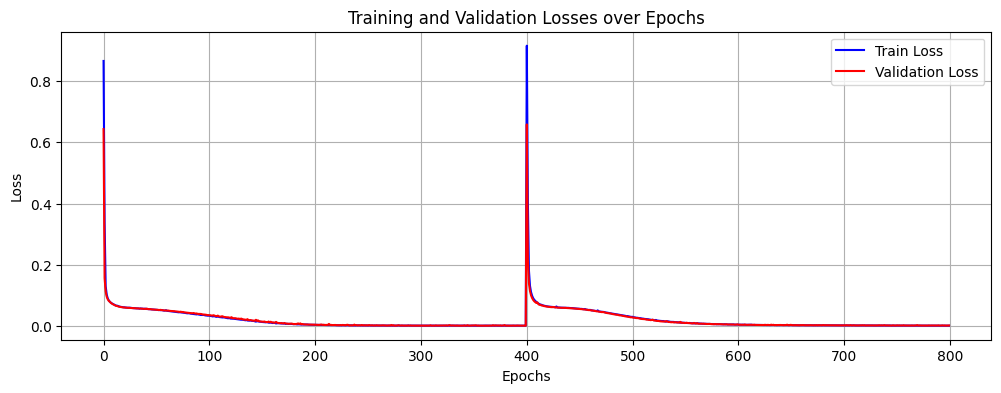

In [73]:
import torch
import torch.optim as optim

# Initialize the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, criterion and optimizer
model = MLP_model().to(device)
criterion = nn.MSELoss()
# Hyperparameters
EPOCHS = 400
LEARNING_RATE = 0.0004
BATCH_SIZE = 32
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataset loading utilities
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
save_folder = '../saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_cross_validation(MLP_model, combined_dataset, k_folds=2, epochs=EPOCHS,batch_size=BATCH_SIZE, lr=LEARNING_RATE, criterion=criterion, device=device, save_folder=save_folder)


In [74]:
# Load the trained model
model_path = "../saved_models/best_mlp_model.pt"
model = MLP_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()

MLP_model(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=2, bias=True)
)

# Add physic-driven model

100%|██████████| 800/800 [00:00<00:00, 3291.71it/s]


sigx1 [0.0, 0.0017323047, 0.0020927042, 0.0024531484, 0.0028135478, 0.0031739622, 0.0035344064, 0.0038948357, 0.004255235, 0.0046156645, 0.004976049, 0.0053364784, 0.0056969076, 0.006057322, 0.006417766, 0.006778151, 0.007138565, 0.0074989945, 0.007859424, 0.008219823, 0.008580267, 0.008940682, 0.009301066, 0.009661511, 0.01002194, 0.010382354, 0.010742754, 0.011103168, 0.011463597, 0.011824027, 0.012184441, 0.01254487, 0.0129053, 0.013265699, 0.013626128, 0.013986543, 0.014346957, 0.014707357, 0.015067816, 0.015428215, 0.01578863, 0.016149059, 0.016509458, 0.016869903, 0.017230302, 0.017590716, 0.01795116, 0.01831156, 0.01867199, 0.019032404, 0.019392803, 0.019753203, 0.020113662, 0.020474061, 0.02083449, 0.021194905, 0.021555334, 0.021915749, 0.022276178, 0.022636563, 0.022997007, 0.023357421, 0.023717836, 0.02407828, 0.024438664, 0.024799079, 0.025159523, 0.025519922, 0.025880352, 0.026240766, 0.026601195, 0.026961625, 0.027322054, 0.027682438, 0.028042868, 0.028403282, 0.028763697,

Text(0.5, 1.0, 'sigx vs CMOD')

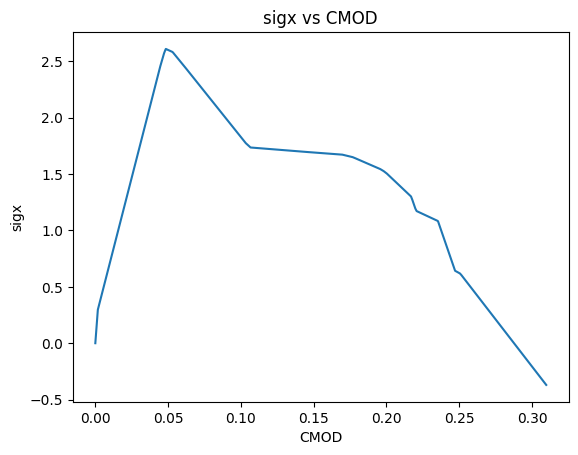

In [75]:
import torch
import torch.optim as optim
import csv
m_input = [i/200 for i in range(0, 800)]  # This will give you values from 0 to 2 with a step of 0.005

E = 20e3
nu = 0.2
sigx = []
CMOD = []
sigx1 = []
CMOD1 = []
combined_sig = []
combined_CMOD = []

for i in tqdm(m_input):
    if i < 0.001:
        # Mesh refinement parameters
        nx, ny = 5, 1
        mesh = RectangleMesh(nx, ny, 1, 1)
        x, y = SpatialCoordinate(mesh)
        V = VectorFunctionSpace(mesh, 'CG', 1)
        # Test and trial function for the displacement field
        v, u_ = TestFunction(V), TrialFunction(V)
        u = Function(V, name="Displacement")

        # Lamé parameter
        lmbda = E*nu/(1+nu)/(1-2*nu)
        mu = E/2/(1+nu)
        # Constitutive equations
        def eps(v):
            return 0.5*(grad(v) + grad(v).T)
        def sigma(v):
            d = 2
            return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
        # Body force
        f = Constant((0.0, 0.0))
        
        # Convert strain tensor into displacement boundary conditions
        exx, eyy, exy = 0, i, 0
        uLx = - exx/2 + exy * (y-.5)
        uLy = eyy * (y-.5) - exy/2
        uRx = exx/2 + exy * (y-.5)
        uRy = eyy * (y-.5) + exy/2
        
        uBx = exx * (x-.5) - exy/2
        uBy = - eyy/2 + exy * (x-.5)
        uTx = exx * (x-.5) + exy/2
        uTy = eyy/2 + exy * (x-.5)

        # Boundary conditions
        bcL = DirichletBC(V, [uLx, uLy], 1)
        bcR = DirichletBC(V, [uRx, uRy], 2)
        bcB = DirichletBC(V, [uBx, uBy], 3)
        bcT = DirichletBC(V, [uTx, uTy], 4)

        # Formal equation is div(sigma(u)) = f
        # Form
        a = inner(sigma(u_), eps(v)) * dx    
        L = inner(f, v) * dx
        # Solve PDE
        solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

        # Boundary stress
        sxx = assemble(.5*sigma(u)[0, 0] * ds(1) + .5*sigma(u)[0, 0] * ds(2))
        syy = assemble(.5*sigma(u)[1, 1] * ds(3) + .5*sigma(u)[1, 1] * ds(4))
        sxy_syx = assemble(.25*sigma(u)[0, 1] * ds(1) +
                        .25*sigma(u)[0, 1] * ds(2) +
                        .25*sigma(u)[1, 0] * ds(3) +
                        .25*sigma(u)[1, 0] * ds(4))
        sigx.append(sxx)
        CMOD.append(eyy)
        # print("sigx",sigx)
        # print("CMOD",CMOD)
    else:
        pred_input = torch.tensor([[i, E, nu], [i,E,nu], [i,E,nu]], dtype=torch.float32)
        pred_input = (pred_input - X_mean) / X_std
        output = model.predict(pred_input)
        output = output[0] * y_std + y_mean
        output = output.detach().numpy()
        sigx1.append(output[0])
        CMOD1.append(output[1])

combined_sigx = sigx + sigx1
combined_CMOD = CMOD + CMOD1
print("sigx1",combined_sigx )
print("CMOD1",combined_CMOD)


print(m_input[1])
plt.plot(combined_sigx, combined_CMOD)
plt.xlabel('CMOD')
plt.ylabel('sigx')
plt.title('sigx vs CMOD')

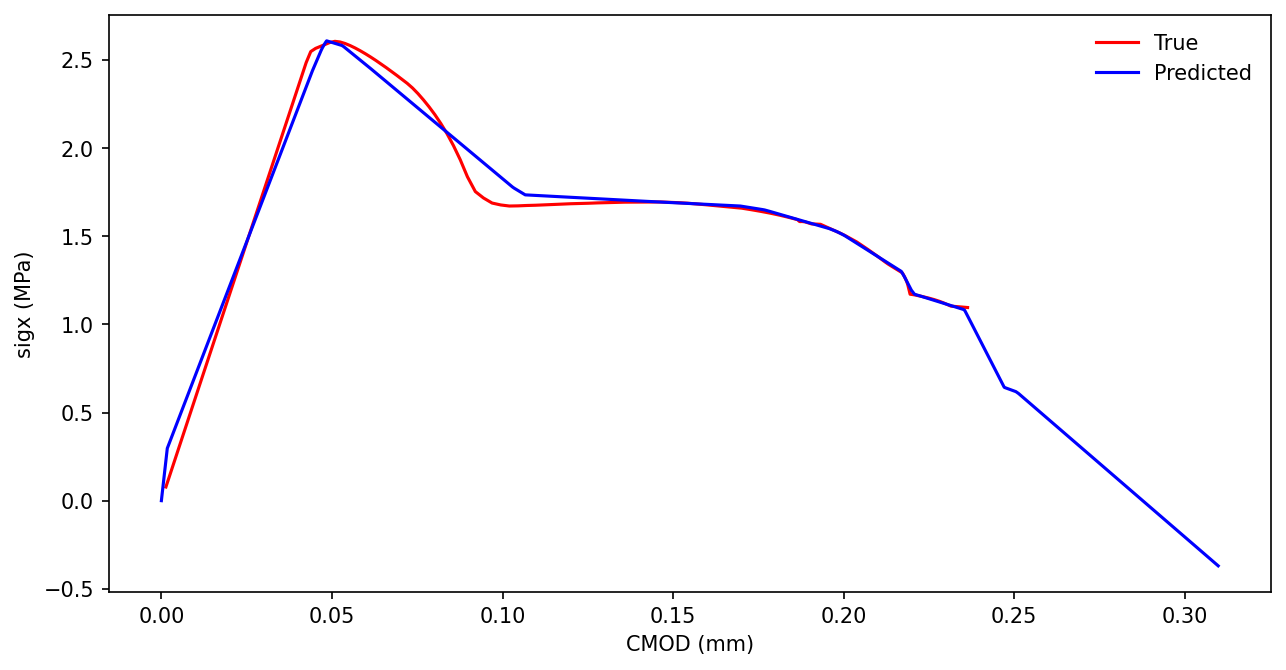

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5), dpi=150)

# Plotting the first dataset
ax.plot(test_data['sigx'], test_data['CMOD'], color='red', label='True')

# Plotting the second dataset
ax.plot(combined_sigx, combined_CMOD, color='blue', label='Predicted')

ax.set_xlabel(r'CMOD (mm)')
ax.set_ylabel(r'sigx (MPa)')
ax.legend(frameon=False, loc='best')

plt.show()
